In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 1000
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
data = run('NQ',breakout, output=True)

weights: 
break_5      0.210019
break_10     0.157716
break_20     0.140819
break_40     0.137508
break_80     0.151062
break_160    0.202876

adjustments:
break_5       17.810321
break_10      26.999459
break_20      38.578236
break_40      55.834685
break_80      78.591353
break_160    123.436168

multiplier:
1.481591861784127

correlations:
            break_5  break_10  break_20  break_40  break_80  break_160
break_5    1.000000  0.709036  0.424716  0.202404  0.088960   0.010686
break_10   0.709036  1.000000  0.777899  0.462852  0.228195   0.065599
break_20   0.424716  0.777899  1.000000  0.760973  0.480340   0.188856
break_40   0.202404  0.462852  0.760973  1.000000  0.813280   0.480735
break_80   0.088960  0.228195  0.480340  0.813280  1.000000   0.775679
break_160  0.010686  0.065599  0.188856  0.480735  0.775679   1.000000

simulation start date: 2019-01-22 21:27:00


In [10]:
data.forecast.abs().mean(), data.forecast.abs().std()

(9.859935748093909, 6.529128787839779)

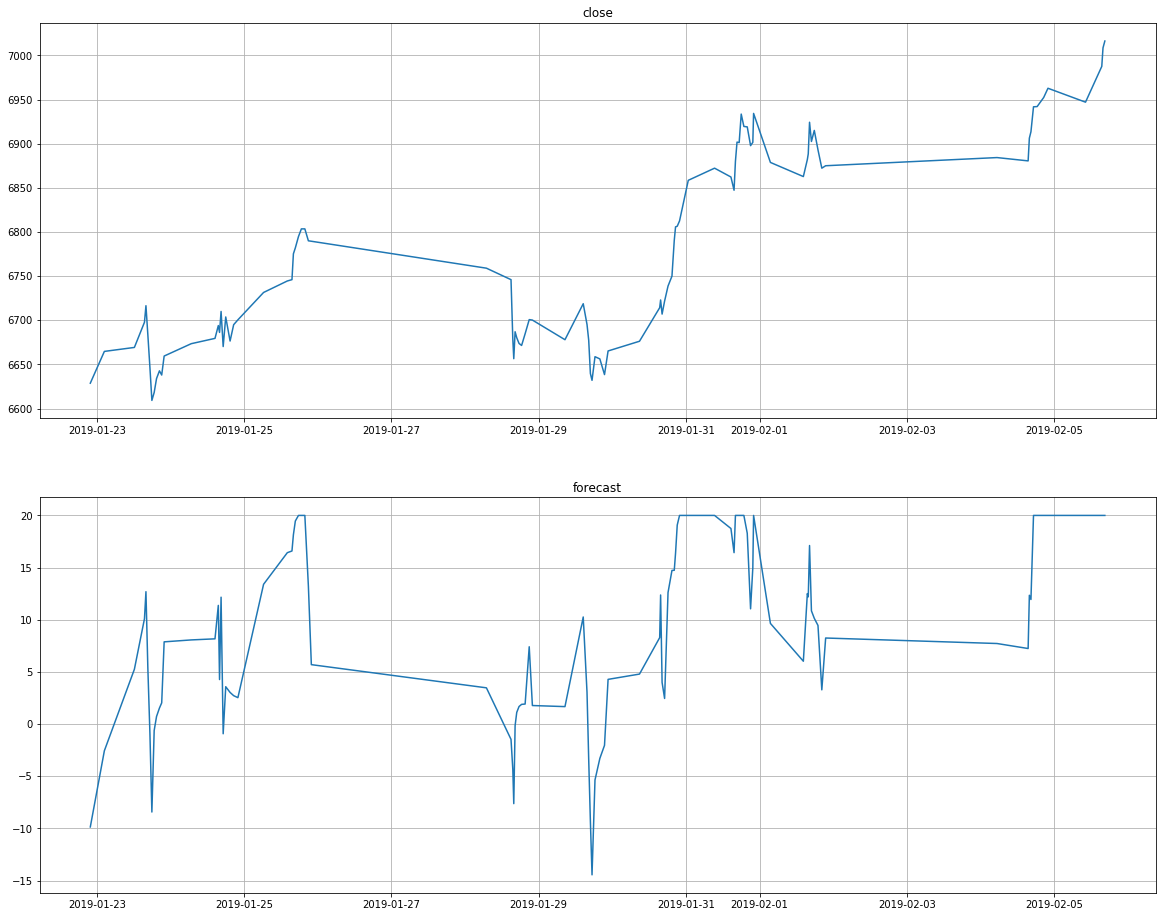

In [11]:
plot(data[['close', 'forecast']].iloc[:100])

In [12]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.216918,0.151734,-0.0373568,0.0240463,-0.0202021,0.00650354,-0.0196525,0.00793457,0.0281324
Cumulative returns,0.135401,0.0956813,-0.0243254,0.0154884,-0.0131143,0.00420184,-0.0127563,0.00512511,0.0181075
Annual volatility,0.16788,0.15672,0.1664,0.154147,0.150162,0.145561,0.117672,0.0867462,0.0652122
Sharpe ratio,1.25318,0.979193,-0.146206,0.230504,-0.061603,0.116515,-0.110398,0.134165,0.457845
Calmar ratio,2.00246,1.70528,-0.290918,0.230053,-0.210972,0.068413,-0.250831,0.183817,1.01621
Stability,0.803217,0.830589,0.212033,0.420562,0.174575,0.0229652,0.0415812,0.242324,0.236969
Max drawdown,-0.108326,-0.0889792,-0.12841,-0.104525,-0.0957573,-0.0950629,-0.0783496,-0.0431655,-0.0276837
Omega ratio,1.23461,1.18241,0.974834,1.04086,0.989113,1.02214,0.97333,1.03677,1.14501
Sortino ratio,1.9151,1.59151,-0.212439,0.353394,-0.0950858,0.181865,-0.171036,0.202139,0.716459
Skew,0.113645,0.618527,0.246599,0.526851,0.719533,0.838863,0.796776,0.379071,0.301099


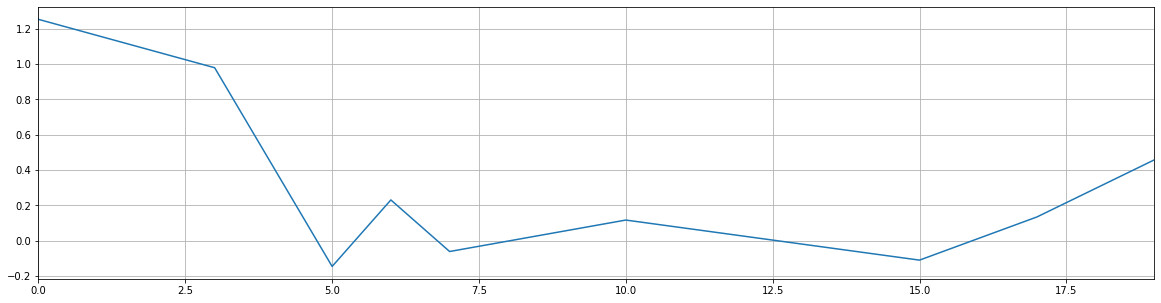

In [13]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [14]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.910158,0.836093,0.819014,0.789204,0.698025,0.575492,0.543175,0.462649
3,0.910158,1.000000,0.914835,0.892177,0.856265,0.765953,0.604612,0.567369,0.500644
5,0.836093,0.914835,1.000000,0.956523,0.905302,0.806800,0.643388,0.540181,0.493088
6,0.819014,0.892177,0.956523,1.000000,0.966562,0.864116,0.685433,0.579804,0.509711
7,0.789204,0.856265,0.905302,0.966562,1.000000,0.891688,0.714570,0.612033,0.544379
10,0.698025,0.765953,0.806800,0.864116,0.891688,1.000000,0.781908,0.639231,0.557054
15,0.575492,0.604612,0.643388,0.685433,0.714570,0.781908,1.000000,0.873585,0.786304
17,0.543175,0.567369,0.540181,0.579804,0.612033,0.639231,0.873585,1.000000,0.878423
19,0.462649,0.500644,0.493088,0.509711,0.544379,0.557054,0.786304,0.878423,1.000000


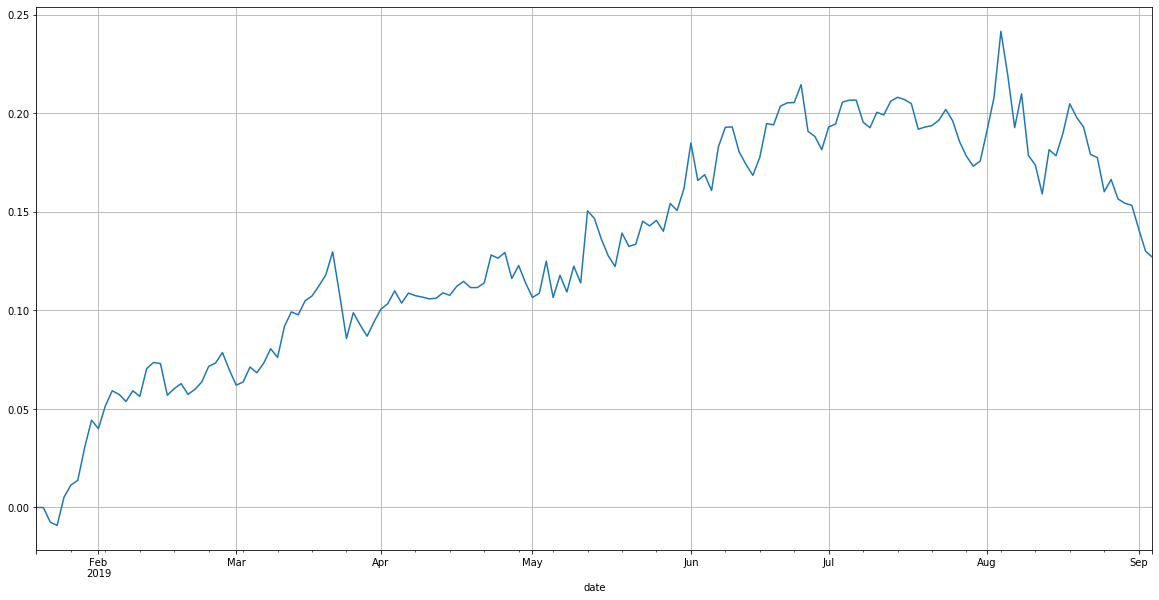

In [15]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

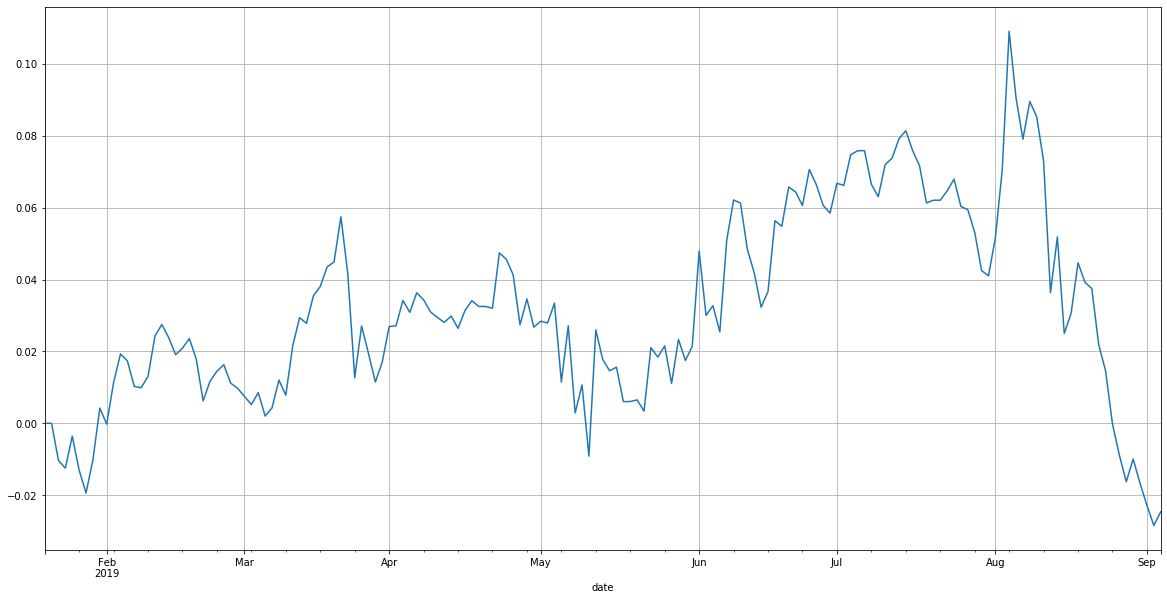

In [16]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

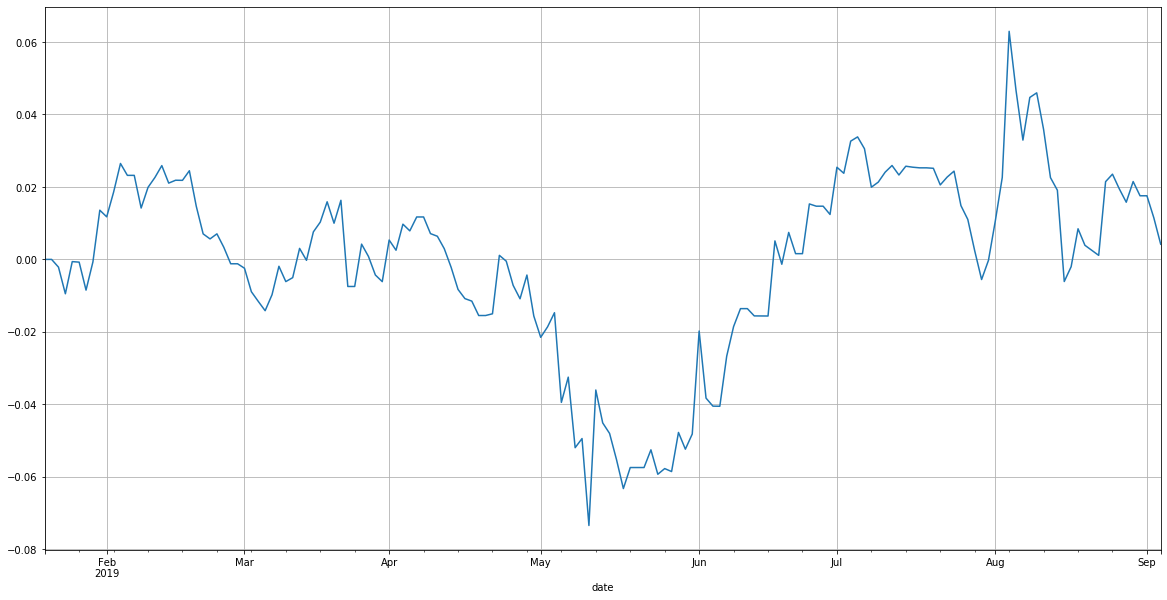

In [17]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);